In [1]:
import numpy as np
import pandas as pd
import glob
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from ipywidgets import interact

### Loading data:


In [2]:
# load 5 years given data

path =r'C:\Users\moja\Downloads\recruitment-challenge-2020-master\data'
filenames = glob.glob(path + "\*.csv")

#list of the given data for 5 years
df_list = []
for filename in filenames:
    df_list.append(pd.read_csv(filename))
    
# Example:
df_list[0].head()   

,Year,Month,Day,1,2,3,4,5,6,7,...,39,40,41,42,43,44,45,46,47,48
0,2015,7,1,5273.441024,5133.091821,4994.505581,4873.605892,4831.396144,5140.329174,5159.066650,...,6779.703506,6755.395335,6695.288132,6526.270261,6409.664775,6289.853567,6122.595618,5963.102617,5825.947731,5674.720985
1,2015,7,2,5888.685259,5728.944816,5582.301034,5454.207187,5365.451134,5313.980779,5269.518294,...,7683.761713,7655.302004,7641.329625,7485.313032,7272.070802,7015.247465,6734.378176,6494.121486,6290.623693,6134.067290
2,2015,7,3,5667.620444,5515.392757,5341.836790,5196.942134,5056.199409,4980.861450,4942.252093,...,7063.751526,7032.080842,7029.178781,6891.966229,6698.359476,6512.647386,6262.692696,6055.310904,5879.653882,5706.724469
3,2015,7,4,5535.836926,5394.299933,5232.641947,5089.031757,4994.850934,4923.002309,4889.630704,...,6894.305737,6863.093659,6860.455040,6699.032822,6490.402292,6318.873948,6146.543885,5959.039287,5820.233400,5636.074844
4,2015,7,5,5482.470351,5331.171354,5182.633170,5063.658062,4968.052846,4918.025886,4879.585556,...,6572.937802,6585.305208,6580.163545,6482.912653,6325.262359,6194.981119,5804.265981,5832.457251,5813.144842,5669.194827


### Creating a baseline of seasonally adjusted 2020 Queensland electricity:

In [3]:
# list of the given data for 5 years excluding the first 3 columns
df_list2 = []

for i in range(0, len(df_list)):
    df_list2.append(df_list[i].iloc[:, 3:])

# Getting average on all 5 years
glued = pd.concat([df_list2[0],df_list2[1],df_list2[2],df_list2[3],df_list2[4]], axis=1, keys=['x', 'y','z', 'u','v'])
avg=glued.groupby(level=1, axis=1).mean()


# Adding back Month and Day columns
df_avg  = pd.concat([df_list[0].iloc[:, 1:3],avg], axis=1)
df_avg.to_csv('2020Prediction.csv', index=False)



##### Function of demand perdiction for a particular selected day:


In [4]:
#Concating 5 years data and converting to numpy arrays
five_years= pd.concat(df_list)
five_years=five_years.to_numpy()

# April
month=4

#Function
def forecast(day):
    
    #list of selected day in 5 years:
    selected_day=[]
    
    # Finding the indices for selected month
    month_indices= np.where(five_years[:,1] == month)

    # Finding the indices for selected day
    day_indices= np.where(five_years[:,2] == day)

    for i in month_indices[0]:
        if i in day_indices[0]:

            selected_day.append(five_years[i,3:])
            
    # Returning predicted demand for selected day in 48 half hourly intervals
    return(sum(selected_day)/5)        


### Loading the daily actual demands (from AEMO) and reshaping 

In [5]:
df_act = pd.read_csv (r'C:\Users\moja\Downloads\recruitment-challenge-2020-master\PRICE_AND_DEMAND_202004_QLD1.csv')
df_act.head()   
    

,REGION,SETTLEMENTDATE,TOTALDEMAND,RRP,PERIODTYPE
0,QLD1,1/04/2020 0:30,5710.84,48.67,TRADE
1,QLD1,1/04/2020 1:00,5604.44,51.50,TRADE
2,QLD1,1/04/2020 1:30,5511.97,49.06,TRADE
3,QLD1,1/04/2020 2:00,5419.03,46.53,TRADE
4,QLD1,1/04/2020 2:30,5406.11,38.32,TRADE


In [6]:
#Splitting the "SETTLEMENTDATE" column to two "Date" and "Time" columns 
df_act2 = pd.DataFrame(df_act.SETTLEMENTDATE.str.split(' ',1).tolist(), columns = ['Day','Time'])
df_act2['Day']=df_act2.Day.str.split('/').str[0]

# Changing the header name and add to the new dataframe
df_act2["Total_demand"]=df_act["TOTALDEMAND"]


# Sorting the dataframe (shifting the last row to the first)
new_col= list(range(2, len(df_act2)+1))
new_col.append(1)
df_act2['Order']= pd.DataFrame(new_col,columns =['Order'])
df_act2=df_act2.sort_values("Order")

df_act2.head()

,Day,Time,Total_demand,Order
1439,1,0:00,5712.23,1
0,1,0:30,5710.84,2
1,1,1:00,5604.44,3
2,1,1:30,5511.97,4
3,1,2:00,5419.03,5


###### Function of actual demand for a particular selected day:


In [7]:
# converting to numpy arrays
act_np=df_act2.to_numpy()

#Function
def actual(day):
    
    #list of selected day in 5 years:
    selected_day=[]
    
    # Finding the indices for selected day
    day_indices= np.where(act_np[:, 0].astype(np.float) == day)
    
    for i in day_indices[0]:
        selected_day.append(act_np[i,2])
        
    # Returning predicted demand for selected day in 48 half hourly intervals    
    return(selected_day)        


## Plotting:


In [8]:
# Daily demand (Prediction VS Actual)

def Total_demand_each_day(i):
    plt.plot(forecast(i), '-b')
    plt.plot(actual(i), '-r')
    plt.legend(["Predict", "Actual"])

    plt.ylabel('Electricity demand')
    plt.xlabel('Half-hour intervals')
    plt.title('Daily demand (Prediction VS Actual)')    

# Slider allows users to select which day to visualise
interact(
    Total_demand_each_day,
    i=(1, 30)
)

interactive(children=(IntSlider(value=15, description='i', max=30, min=1), Output()), _dom_classes=('widget-in…

<function __main__.Total_demand_each_day(i)>

Text(0.5, 1.0, 'Electricity demand for the first weeek of April (Prediction VS Actual)')

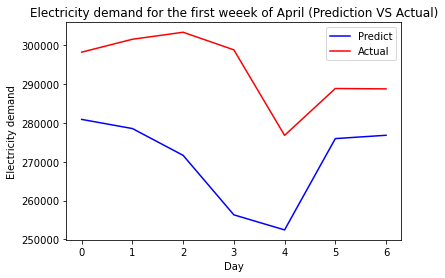

In [9]:
pred_week=[]
act_week=[]

for i in range (1,8):
    pred_week.append(sum(forecast(i)))
    act_week.append(sum(actual(i)))                 


plt.plot(pred_week, '-b')
plt.plot(act_week, '-r')
plt.legend(["Predict", "Actual"])

plt.ylabel('Electricity demand')
plt.xlabel('Day')
plt.title('Electricity demand for the first weeek of April (Prediction VS Actual)')  

## Test:

In [10]:
# Mean Squared Error 
mse = mean_squared_error(forecast(1), actual(1))

# Root Mean Squared Error
rmse=math.sqrt(mse)
print("RMSE:", int(rmse))

RMSE: 418
